<a href="https://colab.research.google.com/github/SandroMuradashvili/The-Georgian-Spellcheck/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
Georgian Spellcheck - Training Notebook
Optimized for Google Colab GPU (~2 hours training)
"""

# ============================================================================
# SETUP & DEPENDENCIES
# ============================================================================

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import requests
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import pickle

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


In [2]:
# ============================================================================
# DATA LOADING FROM GITHUB
# ============================================================================

def load_words_from_github():
    """Load Georgian words from your GitHub repo"""
    url = "https://raw.githubusercontent.com/SandroMuradashvili/The-Georgian-Spellcheck/main/georgian_words_dataset.txt"

    print("Downloading Georgian words from GitHub...")
    response = requests.get(url)
    response.raise_for_status()

    words = response.text.strip().split('\n')
    words = [w.strip() for w in words if w.strip()]

    print(f"Loaded {len(words)} Georgian words")
    return words

# Load data
georgian_words = load_words_from_github()

Loaded 37257 Georgian words


In [3]:
# ============================================================================
# CHARACTER VOCABULARY
# ============================================================================

# Georgian alphabet (Mkhedruli script)
GEORGIAN_CHARS = 'აბგდევზთიკლმნოპჟრსტუფქღყშჩცძწჭხჯჰ'
SPECIAL_TOKENS = ['<PAD>', '<SOS>', '<EOS>', '<UNK>']

# Build character vocabulary
all_chars = set()
for word in georgian_words:
    all_chars.update(word)

# Combine Georgian chars with any other chars found in dataset
vocab_chars = sorted(list(set(GEORGIAN_CHARS) | all_chars))
char_to_idx = {char: idx + len(SPECIAL_TOKENS) for idx, char in enumerate(vocab_chars)}

# Add special tokens
for idx, token in enumerate(SPECIAL_TOKENS):
    char_to_idx[token] = idx

idx_to_char = {idx: char for char, idx in char_to_idx.items()}
vocab_size = len(char_to_idx)

print(f"Vocabulary size: {vocab_size}")
print(f"Special tokens: {SPECIAL_TOKENS}")

# Save vocabulary for inference
vocab_data = {
    'char_to_idx': char_to_idx,
    'idx_to_char': idx_to_char,
    'vocab_size': vocab_size
}
with open('vocab.pkl', 'wb') as f:
    pickle.dump(vocab_data, f)

Vocabulary size: 37
Special tokens: ['<PAD>', '<SOS>', '<EOS>', '<UNK>']


In [4]:

# ============================================================================
# ERROR GENERATION - REALISTIC GEORGIAN KEYBOARD TYPOS
# Georgian keyboard follows QWERTY layout with Georgian letters
# ============================================================================

# Georgian QWERTY keyboard layout (row by row, left to right)
# Row 1: ქ წ ე რ ტ ყ უ ი ო პ
# Row 2: ა ს დ ფ გ ჰ ჯ კ ლ
# Row 3: ზ ხ ც ვ ბ ნ მ

KEYBOARD_ADJACENT = {
    # Row 1
    'ქ': ['წ', 'ა'],
    'წ': ['ქ', 'ე', 'ს'],
    'ე': ['წ', 'რ', 'ს', 'დ'],
    'რ': ['ე', 'ტ', 'დ', 'ფ'],
    'ტ': ['რ', 'ყ', 'ფ', 'გ'],
    'ყ': ['ტ', 'უ', 'გ', 'ჰ'],
    'უ': ['ყ', 'ი', 'ჰ', 'ჯ'],
    'ი': ['უ', 'ო', 'ჯ', 'კ'],
    'ო': ['ი', 'პ', 'კ', 'ლ'],
    'პ': ['ო', 'ლ'],

    # Row 2
    'ა': ['ქ', 'ს', 'ზ'],
    'ს': ['ა', 'წ', 'დ', 'ზ', 'ხ'],
    'დ': ['ს', 'ე', 'ფ', 'ხ', 'ც'],
    'ფ': ['დ', 'რ', 'გ', 'ც', 'ვ'],
    'გ': ['ფ', 'ტ', 'ჰ', 'ვ', 'ბ'],
    'ჰ': ['გ', 'ყ', 'ჯ', 'ბ', 'ნ'],
    'ჯ': ['ჰ', 'უ', 'კ', 'ნ', 'მ'],
    'კ': ['ჯ', 'ი', 'ლ', 'მ'],
    'ლ': ['კ', 'ო', 'პ', 'მ'],

    # Row 3
    'ზ': ['ა', 'ს', 'ხ'],
    'ხ': ['ზ', 'ს', 'დ', 'ც'],
    'ც': ['ხ', 'დ', 'ფ', 'ვ'],
    'ვ': ['ც', 'ფ', 'გ', 'ბ'],
    'ბ': ['ვ', 'გ', 'ჰ', 'ნ'],
    'ნ': ['ბ', 'ჰ', 'ჯ', 'მ'],
    'მ': ['ნ', 'ჯ', 'კ', 'ლ'],

    # Additional Georgian letters (less common)
    'ღ': ['ტ', 'ყ', 'გ', 'ჰ'],
    'შ': ['ა', 'ს', 'დ'],
    'ჩ': ['დ', 'ფ', 'გ'],
    'ძ': ['ს', 'დ', 'ხ', 'ც'],
    'წ': ['ც', 'ვ', 'ბ'],
    'ჭ': ['ვ', 'ბ', 'ნ'],
    'ჟ': ['ო', 'პ', 'კ', 'ლ']
}

def generate_error(word, error_prob=0.15):
    """Generate realistic typo for a Georgian word"""
    if len(word) < 2 or random.random() > error_prob:
        return word

    word_list = list(word)
    error_type = random.choice(['substitute', 'delete', 'insert', 'swap', 'double'])

    if error_type == 'substitute' and len(word) > 0:
        # Substitute with adjacent keyboard character
        pos = random.randint(0, len(word) - 1)
        char = word[pos]
        if char in KEYBOARD_ADJACENT and KEYBOARD_ADJACENT[char]:
            word_list[pos] = random.choice(KEYBOARD_ADJACENT[char])
        else:
            # Random Georgian char if no adjacent defined
            word_list[pos] = random.choice(list(GEORGIAN_CHARS))

    elif error_type == 'delete' and len(word) > 2:
        # Delete a random character
        pos = random.randint(0, len(word) - 1)
        word_list.pop(pos)

    elif error_type == 'insert':
        # Insert a random character
        pos = random.randint(0, len(word))
        word_list.insert(pos, random.choice(list(GEORGIAN_CHARS)))

    elif error_type == 'swap' and len(word) > 1:
        # Swap two adjacent characters
        pos = random.randint(0, len(word) - 2)
        word_list[pos], word_list[pos + 1] = word_list[pos + 1], word_list[pos]

    elif error_type == 'double' and len(word) > 0:
        # Double a character (common typo)
        pos = random.randint(0, len(word) - 1)
        word_list.insert(pos, word_list[pos])

    return ''.join(word_list)

In [5]:
# ============================================================================
# DATASET PREPARATION
# ============================================================================

def create_training_pairs(words, num_samples_per_word=2, correct_word_ratio=0.3):
    """
    Create (input, target) pairs
    - Some pairs are (corrupted_word, correct_word)
    - Some pairs are (correct_word, correct_word) to teach model when NOT to change
    """
    pairs = []

    for word in tqdm(words, desc="Generating training pairs"):
        if len(word) < 2:  # Skip very short words
            continue

        # Add correct word as-is (important!)
        if random.random() < correct_word_ratio:
            pairs.append((word, word))

        # Generate corrupted versions
        for _ in range(num_samples_per_word):
            corrupted = generate_error(word)
            pairs.append((corrupted, word))

    random.shuffle(pairs)
    return pairs

# Generate training data
print("\nGenerating training pairs...")
all_pairs = create_training_pairs(
    georgian_words,
    num_samples_per_word=2,  # 2 corrupted versions per word
    correct_word_ratio=0.3    # 30% already-correct words
)

print(f"Total training pairs: {len(all_pairs)}")

# Show examples
print("\nExample training pairs:")
for i in range(10):
    inp, tgt = all_pairs[i]
    print(f"  {inp:20s} → {tgt}")


Generating training pairs...


Generating training pairs: 100%|██████████| 37257/37257 [00:00<00:00, 225767.10it/s]


Total training pairs: 85614

Example training pairs:
  სიღრმეებთან          → სიღრმეებთან
  თბება                → თბება
  ტნიანი               → ტენიანი
  მიეღით               → მიეღით
  ღიტალურჯი            → ღიალურჯი
  ანდერძებ             → ანდერძები
  ლიბიხი               → ლიბიხი
  აენური               → ატენური
  მხარდამჭერი          → მხარდამჭერი
  შეუპოვარ             → შეუპოვარ


In [6]:
# ============================================================================
# DATASET CLASS
# ============================================================================

class SpellcheckDataset(Dataset):
    def __init__(self, pairs, char_to_idx):
        self.pairs = pairs
        self.char_to_idx = char_to_idx

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        input_word, target_word = self.pairs[idx]

        # Convert to indices
        input_indices = [self.char_to_idx.get(c, self.char_to_idx['<UNK>']) for c in input_word]
        target_indices = [self.char_to_idx['<SOS>']] + \
                        [self.char_to_idx.get(c, self.char_to_idx['<UNK>']) for c in target_word] + \
                        [self.char_to_idx['<EOS>']]

        return torch.tensor(input_indices), torch.tensor(target_indices)

def collate_fn(batch):
    """Pad sequences in batch"""
    inputs, targets = zip(*batch)

    # Pad sequences
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=char_to_idx['<PAD>'])
    targets_padded = pad_sequence(targets, batch_first=True, padding_value=char_to_idx['<PAD>'])

    return inputs_padded, targets_padded

# Split data
split_idx = int(0.9 * len(all_pairs))
train_pairs = all_pairs[:split_idx]
val_pairs = all_pairs[split_idx:]

print(f"\nTrain pairs: {len(train_pairs)}")
print(f"Val pairs: {len(val_pairs)}")

# Create datasets
train_dataset = SpellcheckDataset(train_pairs, char_to_idx)
val_dataset = SpellcheckDataset(val_pairs, char_to_idx)

# DataLoaders with optimized batch size for GPU
BATCH_SIZE = 256  # Large batch for GPU efficiency
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)



Train pairs: 77052
Val pairs: 8562


In [7]:
# ============================================================================
# MODEL ARCHITECTURE - Encoder-Decoder with Attention
# ============================================================================

class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=2, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=char_to_idx['<PAD>'])
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True,
                           dropout=dropout if num_layers > 1 else 0, bidirectional=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        outputs, (hidden, cell) = self.lstm(embedded)
        # outputs: [batch, seq_len, hidden_dim * 2]
        return outputs, (hidden, cell)

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim * 3, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden: [batch, hidden_dim]
        # encoder_outputs: [batch, src_len, hidden_dim * 2]

        src_len = encoder_outputs.shape[1]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)  # [batch, src_len, hidden_dim]

        # Concatenate and compute attention scores
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)  # [batch, src_len]

        return torch.softmax(attention, dim=1)

class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=2, dropout=0.3):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=char_to_idx['<PAD>'])
        self.attention = Attention(hidden_dim)
        self.lstm = nn.LSTM(embed_dim + hidden_dim * 2, hidden_dim, num_layers,
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden, cell, encoder_outputs):
        # x: [batch, 1]
        embedded = self.dropout(self.embedding(x))  # [batch, 1, embed_dim]

        # Calculate attention
        attn_weights = self.attention(hidden[-1], encoder_outputs)  # [batch, src_len]
        attn_weights = attn_weights.unsqueeze(1)  # [batch, 1, src_len]

        # Apply attention to encoder outputs
        context = torch.bmm(attn_weights, encoder_outputs)  # [batch, 1, hidden_dim * 2]

        # Combine embedded input and context
        lstm_input = torch.cat((embedded, context), dim=2)  # [batch, 1, embed_dim + hidden_dim * 2]

        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
        prediction = self.fc(output.squeeze(1))  # [batch, vocab_size]

        return prediction, hidden, cell

class Seq2SeqSpellchecker(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256, num_layers=2, dropout=0.3):
        super().__init__()
        self.encoder = Encoder(vocab_size, embed_dim, hidden_dim, num_layers, dropout)
        self.decoder = Decoder(vocab_size, embed_dim, hidden_dim, num_layers, dropout)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        trg_len = trg.shape[1]

        # Encoder
        encoder_outputs, (hidden, cell) = self.encoder(src)

        # Combine bidirectional hidden states
        hidden = hidden.view(self.num_layers, 2, batch_size, self.hidden_dim)
        hidden = hidden.permute(0, 2, 1, 3).contiguous().view(self.num_layers, batch_size, -1)
        hidden = hidden[:, :, :self.hidden_dim].contiguous()

        cell = cell.view(self.num_layers, 2, batch_size, self.hidden_dim)
        cell = cell.permute(0, 2, 1, 3).contiguous().view(self.num_layers, batch_size, -1)
        cell = cell[:, :, :self.hidden_dim].contiguous()

        # Decoder
        outputs = torch.zeros(batch_size, trg_len, self.decoder.vocab_size).to(src.device)
        input_token = trg[:, 0].unsqueeze(1)  # <SOS> token

        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input_token, hidden, cell, encoder_outputs)
            outputs[:, t] = output

            # Teacher forcing
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1).unsqueeze(1)
            input_token = trg[:, t].unsqueeze(1) if teacher_force else top1

        return outputs

# Initialize model
model = Seq2SeqSpellchecker(
    vocab_size=vocab_size,
    embed_dim=128,
    hidden_dim=256,
    num_layers=2,
    dropout=0.3
).to(device)

print(f"\nModel parameters: {sum(p.numel() for p in model.parameters()):,}")


Model parameters: 4,029,477


In [8]:
# ============================================================================
# TRAINING SETUP
# ============================================================================

criterion = nn.CrossEntropyLoss(ignore_index=char_to_idx['<PAD>'])
optimizer = optim.Adam(model.parameters(), lr=0.001)
# FIXED: Removed verbose parameter (not supported in older PyTorch)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Mixed precision for speed (only if CUDA available)
scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

/tmp/ipython-input-3229798017.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


In [9]:
# ============================================================================
# TRAINING FUNCTIONS
# ============================================================================

def train_epoch(model, loader, optimizer, criterion, scaler=None):
    model.train()
    total_loss = 0

    for src, trg in tqdm(loader, desc="Training"):
        src, trg = src.to(device), trg.to(device)

        optimizer.zero_grad()

        if scaler:  # Mixed precision
            with torch.cuda.amp.autocast():
                output = model(src, trg)
                output = output[:, 1:].reshape(-1, output.shape[-1])
                trg = trg[:, 1:].reshape(-1)
                loss = criterion(output, trg)

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
            scaler.step(optimizer)
            scaler.update()
        else:
            output = model(src, trg)
            output = output[:, 1:].reshape(-1, output.shape[-1])
            trg = trg[:, 1:].reshape(-1)
            loss = criterion(output, trg)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
            optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for src, trg in loader:
            src, trg = src.to(device), trg.to(device)

            output = model(src, trg, teacher_forcing_ratio=0)
            output = output[:, 1:].reshape(-1, output.shape[-1])
            trg = trg[:, 1:].reshape(-1)

            loss = criterion(output, trg)
            total_loss += loss.item()

    return total_loss / len(loader)



In [10]:
# ============================================================================
# TRAINING LOOP
# ============================================================================

NUM_EPOCHS = 20
EARLY_STOP_PATIENCE = 5

train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0

print("\n" + "="*50)
print("TRAINING START")
print("="*50 + "\n")

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")

    train_loss = train_epoch(model, train_loader, optimizer, criterion, scaler)
    val_loss = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Learning rate scheduling
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Learning Rate: {current_lr:.6f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, 'best_model.pt')
        print(f"✓ New best model saved (val_loss: {val_loss:.4f})")
        patience_counter = 0
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= EARLY_STOP_PATIENCE:
        print(f"\nEarly stopping triggered after {epoch + 1} epochs")
        break

print("\n" + "="*50)
print("TRAINING COMPLETE")
print("="*50)


TRAINING START


Epoch 1/20


Training:   0%|          | 0/301 [00:00<?, ?it/s]/tmp/ipython-input-2824305789.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 301/301 [00:29<00:00, 10.14it/s]


Train Loss: 2.7712 | Val Loss: 2.6951
Learning Rate: 0.001000
✓ New best model saved (val_loss: 2.6951)

Epoch 2/20


Training: 100%|██████████| 301/301 [00:27<00:00, 11.06it/s]


Train Loss: 2.4183 | Val Loss: 2.3446
Learning Rate: 0.001000
✓ New best model saved (val_loss: 2.3446)

Epoch 3/20


Training: 100%|██████████| 301/301 [00:28<00:00, 10.58it/s]


Train Loss: 1.7903 | Val Loss: 1.8280
Learning Rate: 0.001000
✓ New best model saved (val_loss: 1.8280)

Epoch 4/20


Training: 100%|██████████| 301/301 [00:26<00:00, 11.16it/s]


Train Loss: 0.7034 | Val Loss: 0.4790
Learning Rate: 0.001000
✓ New best model saved (val_loss: 0.4790)

Epoch 5/20


Training: 100%|██████████| 301/301 [00:27<00:00, 11.10it/s]


Train Loss: 0.3215 | Val Loss: 0.3322
Learning Rate: 0.001000
✓ New best model saved (val_loss: 0.3322)

Epoch 6/20


Training: 100%|██████████| 301/301 [00:27<00:00, 10.93it/s]


Train Loss: 0.2407 | Val Loss: 0.3049
Learning Rate: 0.001000
✓ New best model saved (val_loss: 0.3049)

Epoch 7/20


Training: 100%|██████████| 301/301 [00:26<00:00, 11.16it/s]


Train Loss: 0.1945 | Val Loss: 0.2954
Learning Rate: 0.001000
✓ New best model saved (val_loss: 0.2954)

Epoch 8/20


Training: 100%|██████████| 301/301 [00:26<00:00, 11.17it/s]


Train Loss: 0.1679 | Val Loss: 0.2732
Learning Rate: 0.001000
✓ New best model saved (val_loss: 0.2732)

Epoch 9/20


Training: 100%|██████████| 301/301 [00:27<00:00, 10.94it/s]


Train Loss: 0.1604 | Val Loss: 0.2761
Learning Rate: 0.001000

Epoch 10/20


Training: 100%|██████████| 301/301 [00:26<00:00, 11.17it/s]


Train Loss: 0.1534 | Val Loss: 0.2879
Learning Rate: 0.001000

Epoch 11/20


Training: 100%|██████████| 301/301 [00:27<00:00, 11.06it/s]


Train Loss: 0.1468 | Val Loss: 0.2528
Learning Rate: 0.001000
✓ New best model saved (val_loss: 0.2528)

Epoch 12/20


Training: 100%|██████████| 301/301 [00:27<00:00, 11.05it/s]


Train Loss: 0.1395 | Val Loss: 0.2666
Learning Rate: 0.001000

Epoch 13/20


Training: 100%|██████████| 301/301 [00:26<00:00, 11.20it/s]


Train Loss: 0.1353 | Val Loss: 0.2614
Learning Rate: 0.001000

Epoch 14/20


Training: 100%|██████████| 301/301 [00:26<00:00, 11.19it/s]


Train Loss: 0.1256 | Val Loss: 0.2496
Learning Rate: 0.001000
✓ New best model saved (val_loss: 0.2496)

Epoch 15/20


Training: 100%|██████████| 301/301 [00:27<00:00, 11.08it/s]


Train Loss: 0.1227 | Val Loss: 0.2459
Learning Rate: 0.001000
✓ New best model saved (val_loss: 0.2459)

Epoch 16/20


Training: 100%|██████████| 301/301 [00:27<00:00, 11.02it/s]


Train Loss: 0.1185 | Val Loss: 0.2455
Learning Rate: 0.001000
✓ New best model saved (val_loss: 0.2455)

Epoch 17/20


Training: 100%|██████████| 301/301 [00:27<00:00, 11.14it/s]


Train Loss: 0.1177 | Val Loss: 0.2422
Learning Rate: 0.001000
✓ New best model saved (val_loss: 0.2422)

Epoch 18/20


Training: 100%|██████████| 301/301 [00:26<00:00, 11.17it/s]


Train Loss: 0.1139 | Val Loss: 0.2436
Learning Rate: 0.001000

Epoch 19/20


Training: 100%|██████████| 301/301 [00:27<00:00, 11.11it/s]


Train Loss: 0.1129 | Val Loss: 0.2409
Learning Rate: 0.001000
✓ New best model saved (val_loss: 0.2409)

Epoch 20/20


Training: 100%|██████████| 301/301 [00:26<00:00, 11.17it/s]


Train Loss: 0.1111 | Val Loss: 0.2428
Learning Rate: 0.001000

TRAINING COMPLETE


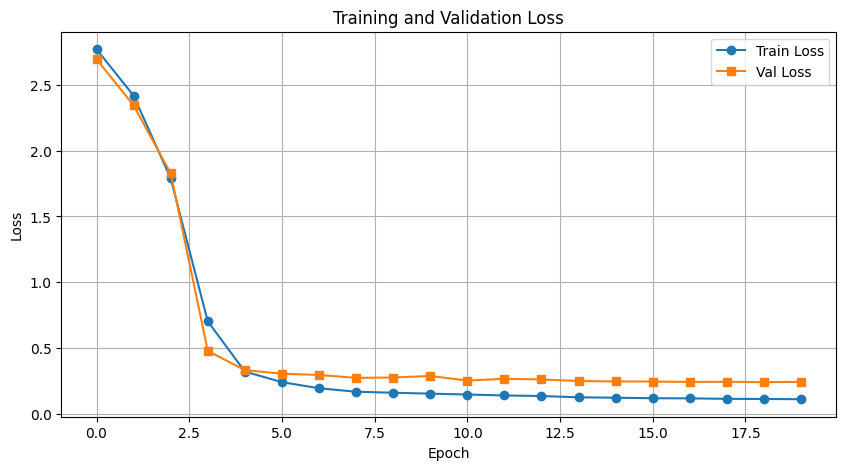


Best validation loss: 0.2409
Model saved as: best_model.pt
Vocabulary saved as: vocab.pkl

Files ready for inference notebook!


In [11]:
# ============================================================================
# PLOT TRAINING CURVES
# ============================================================================

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nBest validation loss: {best_val_loss:.4f}")
print("Model saved as: best_model.pt")
print("Vocabulary saved as: vocab.pkl")
print("\nFiles ready for inference notebook!")